In [10]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import warnings

from scipy import ndimage
from skimage import filters

from PIL import Image
warnings.simplefilter('ignore')

In [3]:
data_dir = '/home/molel/OneDrive/PhD/Data/silicon_xct'

In [4]:
subfolders = ['horizonal-cross-sections', 'vertical-cross-sections', 'segmented-crack-volumes']

In [7]:
delith_data_path = os.path.join(data_dir, 'segmented-crack-volumes', 'De-lith segmented crack volume (top down).gif')

with tf.io.gfile.GFile(delith_data_path, 'rb') as f:
    video = tf.io.decode_gif(f.read())
    data_delith = np.array(video)

for i in range(data_delith.shape[0]):
    img = Image.fromarray(data_delith[i, :, :, :])
    img.save(os.path.join(data_dir, 'segmented-crack-volumes/delithiated', str(i).zfill(3) + ".tif"))

In [5]:
lith_data_path = os.path.join(data_dir, 'segmented-crack-volumes', 'Re-lith segmented crack volume (top-down).gif')

with tf.io.gfile.GFile(lith_data_path, 'rb') as f:
    video = tf.io.decode_gif(f.read())
    data_lith = np.array(video)

for i in range(data_lith.shape[0]):
    img = Image.fromarray(data_lith[i, :, :, :])
    img.save(os.path.join(data_dir, 'segmented-crack-volumes/lithiated', str(i).zfill(3) + ".tif"))

2023-06-28 17:34:52.762927: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'data_delith' is not defined

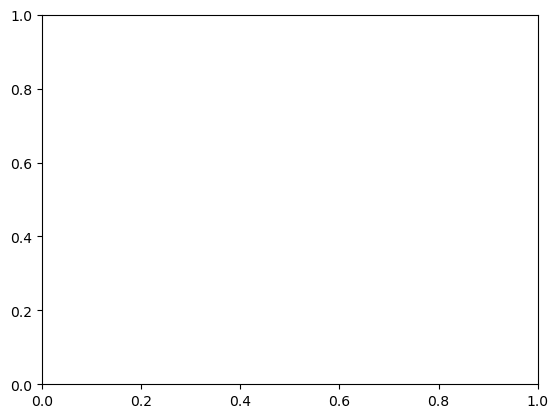

In [5]:
fig, ax = plt.subplots()
ax.imshow(data_delith[0, :, :, 0])
plt.tight_layout()

In [17]:
idx = 1
img = plt.imread(os.path.join(data_dir, 'segmented-crack-volumes/lithiated', str(idx).zfill(3) + ".tif"))

In [18]:
img_edges = filters.meijering(img)

In [12]:
img_edges.shape

(1061, 1920, 3)

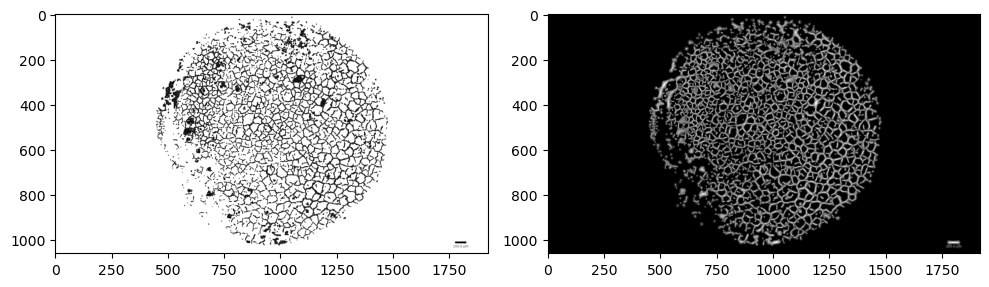

In [16]:
fig, ax  = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(img)
ax[1].imshow(img_edges)
plt.tight_layout()

In [61]:
cracks = np.greater_equal(img_edges[:, :, 0], 0.01)
cracks[:, 1600:] = 0
coords = np.where(np.greater(cracks, 0))
ycom, xcom = map(np.average, coords)

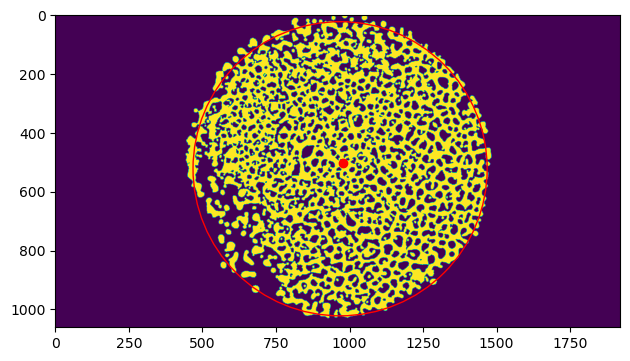

In [85]:
fig, ax = plt.subplots()
ax.imshow(cracks);
ax.plot([xcom], [ycom], 'o', color='red');
circle = plt.Circle((xcom - 10, ycom + 20), 500, fill=False, color='r')
ax.add_patch(circle)
plt.tight_layout()